In [50]:
import torch.nn as nn
import torch
import torch.optim as optim

from vecopsciml.algebra import zero_order as azo
from vecopsciml.operators import zero_order as zo
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import Tensor

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
from linear_homogeneous.config import DATASET_CONFIG
from linear_homogeneous.data_generator import DataGenerator

# Cargar configuración
config = DATASET_CONFIG
generator = DataGenerator(config)

# Generar y guardar datos
dataset = generator.generate_dataset()

In [53]:
def pi1_constraint(y_pred, K_pred, D):

    y_pred = Tensor(y_pred, space_dimension=2, order=0)
    K_pred = Tensor(K_pred, space_dimension=2, order=0)

    dy = zo.gradient(y_pred, D)

    qx = Tensor(-torch.mul(K_pred.values, dy.values[:, 0].unsqueeze(1)), space_dimension=2, order=0)
    qy = Tensor(-torch.mul(K_pred.values, dy.values[:, 1].unsqueeze(1)), space_dimension=2, order=0)

    dqxdx = zo.gradient(qx, D).values[:, 0].unsqueeze(1)
    dqydy = zo.gradient(qy, D).values[:, 1].unsqueeze(1)

    pi1 = dqxdx + dqydy

    return Tensor(pi1, space_dimension=2, order=0)
    # return pi1


# Constraint e
def e_constraint(y_true, y_pred):

    y_pred = Tensor(y_pred, y_true.space_dim, y_true.order)
    e = azo.subtraction(y_true, y_pred)
    return e


# Constraint pi2
def pi2_constraint(X_true, y_pred):

    X_true = X_true.values
    y_pred = y_pred

    return torch.concat([y_pred[:, :, :, 0].unsqueeze(1) - X_true[:, :, :, 0].unsqueeze(1),
                         y_pred[:, :, :, -1].unsqueeze(1) - X_true[:, :, :, 1].unsqueeze(1), 
                         y_pred[:, :, 0].unsqueeze(1) - X_true[:, :, :, 2].unsqueeze(1),
                         y_pred[:, :, -1].unsqueeze(1) - X_true[:, :, :, 3].unsqueeze(1),
                         ], dim=1)

# Constraint pi3
def pi3_constraint(X_true, y_pred, K_pred, D):
    
    y_pred = Tensor(y_pred, space_dimension=2, order=0)
    K_pred = Tensor(K_pred, space_dimension=2, order=0)

    dy = zo.gradient(y_pred, D)

    qx_pred = -torch.mul(K_pred.values, dy.values[:, 0].unsqueeze(1)) 
    qy_pred = -torch.mul(K_pred.values, dy.values[:, 1].unsqueeze(1))

    X_true_red = (zo.My(X_true)).values

    return torch.concat([qx_pred[:, :, :, 0].unsqueeze(1) - X_true_red[:, :, :, 4].unsqueeze(1),
                         qx_pred[:, :, :, -1].unsqueeze(1) - X_true_red[:, :, :, 5].unsqueeze(1),
                         qy_pred[:, :, :, 0].unsqueeze(1) - X_true_red[:, :, :, 6].unsqueeze(1),
                         qy_pred[:, :, :, -1].unsqueeze(1) - X_true_red[:, :, :, 7].unsqueeze(1),
                         ], dim=1)


# MSE as defined in the paper: sum of all the squarers of all the components of a tensor
def MSE(diff_tensor):
    if isinstance(diff_tensor, torch.Tensor):
        return torch.sum(torch.square(diff_tensor))
    else:
        return torch.sum(torch.square(diff_tensor.values))

In [54]:
def custom_loss(X_true, y_true, y_pred, K_pred, D):

    e = MSE(e_constraint(y_true, y_pred))
    pi1 = MSE(pi1_constraint(y_pred, K_pred, D))
    pi2 = MSE(pi2_constraint(X_true, y_pred))
    pi3 = MSE(pi3_constraint(X_true, y_pred, K_pred, D))

    total_loss = 1e7*e + 1e4*pi1 + 1e3*pi2 + 1e5*pi3

    return total_loss, e, pi1, pi2, pi3

In [55]:
class ConstantDiffusivityNeuralNetwork(nn.Module):

    def __init__(self, input_size, hidden1_dim, hidden2_dim, output_size):
        super(ConstantDiffusivityNeuralNetwork, self).__init__()

        self.input_size = input_size
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.output_size = output_size

        # Predictive network
        self.flatten_layer_pred = nn.Flatten()
        self.hidden1_layer_pred = nn.Linear(torch.prod(torch.tensor(self.input_size)), self.hidden1_dim)  # Ajusta las dimensiones de entrada y salida
        self.hidden2_layer_pred = nn.Linear(self.hidden1_dim, self.hidden2_dim)  # Ajusta según el tamaño de la salida de hidden1
        self.output_layer_pred = nn.Linear(self.hidden2_dim, self.output_size[1] * self.output_size[2])  # Ajusta según el tamaño de la salida de hidden2


        # Matrix of trainable parameters
        self.weight_matrix = nn.Parameter(torch.randn(output_size[0], output_size[1] - 1, output_size[2] - 1))

    def forward(self, X):

        # Predictive network
        X_pred_flat = self.flatten_layer_pred(X)
        X_pred_hidden1 = torch.sigmoid(self.hidden1_layer_pred(X_pred_flat))
        X_pred_hidden2 = torch.sigmoid(self.hidden2_layer_pred(X_pred_hidden1))
        output_dense_pred = torch.sigmoid(self.output_layer_pred(X_pred_hidden2))

        # Outputs 
        u_pred = output_dense_pred.view(-1, 1, self.output_size[1], self.output_size[2])
        K_pred = self.weight_matrix

        return u_pred, K_pred

In [56]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_shape, hidden1_dim, hidden2_dim, output_shape):
        super(FeedforwardNN, self).__init__()
        
        # Calcular el tamaño "plano" de la entrada y la salida
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]  # Flatten de [1, 10, 8] a 80
        output_dim = output_shape[0] * output_shape[1] * output_shape[2]  # Flatten de [1, 10, 10] a 100

        # Definir las capas completamente conectadas (lineales)
        self.fc1 = nn.Linear(input_dim, hidden1_dim)  # Primera capa oculta
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)  # Segunda capa oculta
        self.fc3 = nn.Linear(hidden2_dim, output_dim)  # Capa de salida
        
    def forward(self, x):
        # Aplanar la entrada (flatten) de [1, 10, 8] a [80] para pasar por capas lineales
        x = x.view(x.size(0), -1)
        
        # Pasar por las capas completamente conectadas con activación ReLU
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        # Capa final de salida (no es necesario aplicar activación si es regresión)
        x = self.fc3(x)
        
        # Cambiar la forma de vuelta a [1, 10, 10] (o como sea la salida esperada)
        x = x.view(x.size(0), *output_shape)
        return x

In [57]:
############ ------------------------------------
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

X_train = Tensor(torch.tensor(dataset['X_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)
y_train = Tensor(torch.tensor(dataset['y_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)
K_train = Tensor(torch.tensor(dataset['k_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)

X_val = Tensor(torch.tensor(dataset['X_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)
y_val = Tensor(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)
K_val = Tensor(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, order=0)

X_np = X_train.values
y_np = y_train.values
K_np = K_train.values


X_train_np, X_test_np, y_train_np, y_test_np, K_train_np, K_test_np = train_test_split(X_np, y_np, K_np, test_size=0.2, random_state=42)

X_train = Tensor(X_train_np, space_dimension=X_train.space_dim, order=X_train.order)
X_test = Tensor(X_test_np, space_dimension=X_train.space_dim, order=X_train.order)

y_train = Tensor(y_train_np, space_dimension=y_train.space_dim, order=y_train.order)
y_test = Tensor(y_test_np, space_dimension=y_train.space_dim, order=y_train.order)

K_train = Tensor(K_train_np, space_dimension=K_train.space_dim, order=K_train.order)
K_test = Tensor(K_test_np, space_dimension=K_train.space_dim, order=K_train.order)

In [58]:
# Cargar modelo con las formas de entrada y salida
input_shape = X_train.values[0].shape  # [1, 10, 8]
output_shape = y_train.values[0].shape  # [1, 10, 10]

# Dimensiones ocultas
hidden1_dim = 10
hidden2_dim = 10

# Crear el modelo
model = ConstantDiffusivityNeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

In [60]:
import matplotlib.pyplot as plt

# Lists to store the losses
losses = []
e_losses = []
pi1_losses = []
pi2_losses = []
pi3_losses = []

for epoch in range(100000):
    model.train()
    
    # Forward pass
    y_pred, K_pred = model(X_train.values)
    
    # Calculate the custom loss
    loss, e_loss, pi1_loss, pi2_loss, pi3_loss = custom_loss(X_train, y_train, y_pred, K_pred, D)

    if epoch % 1000 == 0:
        print("epoch", epoch, "loss", loss.item())

    # Store the losses
    losses.append(loss.item())
    e_losses.append(e_loss.item())
    pi1_losses.append(pi1_loss.item())
    pi2_losses.append(pi2_loss.item())
    pi3_losses.append(pi3_loss.item())

    optimizer.zero_grad() 
    loss.backward(retain_graph=True)
    optimizer.step()

epoch 0 loss 78168391680.0
epoch 1000 loss 15544779776.0
epoch 2000 loss 2544701184.0
epoch 3000 loss 1148105088.0
epoch 4000 loss 657723584.0
epoch 5000 loss 375178496.0
epoch 6000 loss 240437584.0
epoch 7000 loss 177228096.0
epoch 8000 loss 140354288.0
epoch 9000 loss 114223320.0
epoch 10000 loss 93564192.0
epoch 11000 loss 77604280.0
epoch 12000 loss 66667160.0
epoch 13000 loss 59654788.0
epoch 14000 loss 54796164.0
epoch 15000 loss 51072392.0
epoch 16000 loss 48001764.0
epoch 17000 loss 45005344.0
epoch 18000 loss 42459616.0
epoch 19000 loss 39666524.0
epoch 20000 loss 36800260.0
epoch 21000 loss 33050420.0
epoch 22000 loss 29982310.0
epoch 23000 loss 27345068.0
epoch 24000 loss 24141174.0
epoch 25000 loss 21314508.0
epoch 26000 loss 17934172.0
epoch 27000 loss 16094038.0
epoch 28000 loss 15324846.0
epoch 29000 loss 14517376.0
epoch 30000 loss 14065977.0
epoch 31000 loss 13580005.0
epoch 32000 loss 13236616.0
epoch 33000 loss 12750112.0
epoch 34000 loss 12479241.0
epoch 35000 loss 

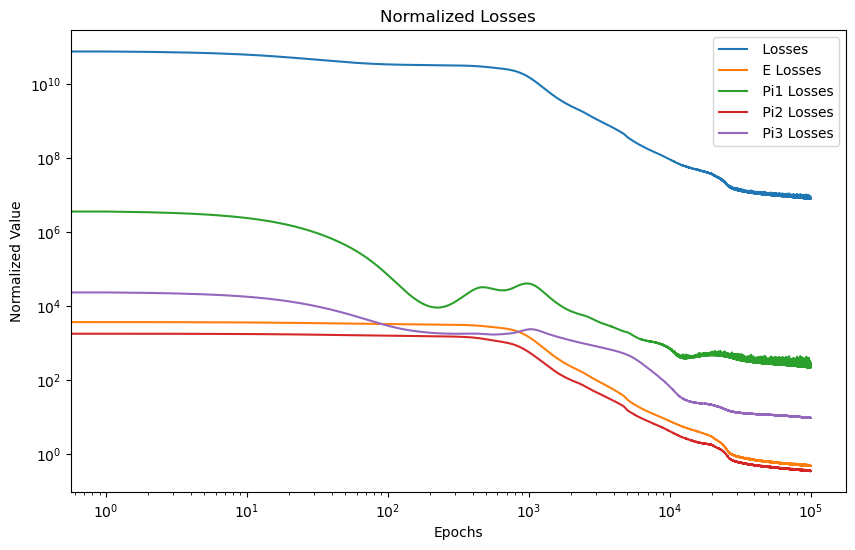

In [61]:
import numpy as np

# Función para normalizar listas
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Normalizar las listas
normalized_losses = normalize(np.array(losses))
normalized_e_losses = normalize(np.array(e_losses))
normalized_pi1_losses = normalize(np.array(pi1_losses))
normalized_pi2_losses = normalize(np.array(pi2_losses))
normalized_pi3_losses = normalize(np.array(pi3_losses))

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(losses, label=' Losses')
plt.plot(e_losses, label=' E Losses')
plt.plot(pi1_losses, label=' Pi1 Losses')
plt.plot(pi2_losses, label=' Pi2 Losses')
plt.plot(pi3_losses, label=' Pi3 Losses')

# Añadir leyenda y etiquetas
plt.title('Normalized Losses')
plt.xlabel('Epochs')
plt.ylabel('Normalized Value')
plt.legend()
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.show()